In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

import sys
sys.path.append("/usr/gapps/spot/live/hatchet")
import hatchet as ht

dataset_dir = "/usr/workspace/wsb/asde/hatchet-sc19-datasets"

In [2]:
# Figure 9:  Generating a flat profile in Hatchet using the groupby functionality of pandas. Traditional tools create
# a flat profile based on function names or callsite labels. In Hatchet, you can choose any categorical column to
# group by: name of the function (left figure), load module (middle figure), or file (right figure).
hpct_kripke = dataset_dir + "/kripke-mpi/mvapich2.3/hpctoolkit-kripke-database-2589696"
gf = ht.GraphFrame.from_hpctoolkit(hpct_kripke)

# groupby name
grouped = gf.dataframe.groupby("name").sum()
display(HTML(grouped.to_html()))

,time (inc),time,nid,line
name,,,,
100:MPIDI_CH3_Request_destroy,5.983000e+03,0.000000e+00,47744,15616
1022:MPIR_Allreduce_impl,1.677993e+06,0.000000e+00,93312,49344
104:<unknown procedure> 0x58860 [libstdc++.so.6.0.20],1.197300e+04,0.000000e+00,67456,0
1076:MPIR_Reduce_MV2,5.788758e+06,0.000000e+00,178496,260608
109:MPID_Request_create,2.392100e+04,0.000000e+00,65152,3648
111:_dl_lookup_symbol_x,1.195400e+04,0.000000e+00,107584,91648
113:_intel_fast_memcpy,5.989000e+03,0.000000e+00,77760,0
114:<unknown procedure> 0x143100 [libmpi.so.12.1.1],2.985000e+04,0.000000e+00,23424,0
114:__GI___libc_malloc,4.468137e+06,0.000000e+00,23552,185216


In [3]:
# groupby module
grouped = gf.dataframe.groupby("module").sum()
display(HTML(grouped.to_html()))

,time (inc),time,nid,line
module,,,,
/collab/usr/global/tools/hpctoolkit/toss_3_x86_64_ib/2019-02-26/packages/linux-rhel7-x86_64/gcc-4.9.3/hpctoolkit-develop-szfcj5uplk66ruwembpihb7kexoonoti/lib/hpctoolkit/ext-libs/libmonitor.so.0.0.0,1.227871e+10,0.000000e+00,160768,0
/g/g92/bhatele1/llnl/hpctoolkit/Kripke/build-mvapich2.3/kripke,3.742715e+10,1.168513e+10,919424,0
/usr/lib64/ld-2.17.so,5.978000e+04,0.000000e+00,619264,192320
/usr/lib64/libc-2.17.so,4.576352e+08,0.000000e+00,2430080,5599616
/usr/lib64/libdl-2.17.so,1.794600e+04,0.000000e+00,283328,18112
/usr/lib64/libpsm2.so.2.1,1.597464e+08,0.000000e+00,27728128,0
/usr/lib64/libpthread-2.17.so,2.991600e+04,0.000000e+00,171456,4992
/usr/tce/packages/gcc/gcc-4.9.3/lib64/libstdc++.so.6.0.20,2.495027e+07,0.000000e+00,956480,299904
/usr/tce/packages/intel/intel-18.0.1/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin/libintlc.so.5,5.989000e+03,0.000000e+00,77760,0


In [4]:
# groupby file
grouped = gf.dataframe.groupby("file").sum()
display(HTML(grouped.to_html()))

,time (inc),time,nid,line
file,,,,
./src/usr/include/pthread.h,1.197200e+04,5.986000e+03,185536,148224
./src/usr/src/debug/glibc-2.17-c758a686/dlfcn/dlerror.c,5.982000e+03,0.000000e+00,94400,10432
./src/usr/src/debug/glibc-2.17-c758a686/dlfcn/dlsym.c,1.196400e+04,0.000000e+00,188928,7680
./src/usr/src/debug/glibc-2.17-c758a686/elf/dl-error.c,5.982000e+03,0.000000e+00,94528,11328
./src/usr/src/debug/glibc-2.17-c758a686/elf/dl-lookup.c,4.782600e+04,1.793600e+04,513280,209088
./src/usr/src/debug/glibc-2.17-c758a686/elf/dl-runtime.c,1.195400e+04,0.000000e+00,107328,14208
./src/usr/src/debug/glibc-2.17-c758a686/elf/dl-sym.c,5.982000e+03,0.000000e+00,94784,10944
./src/usr/src/debug/glibc-2.17-c758a686/malloc/malloc.c,1.190002e+08,5.921833e+07,11537280,52558528
./src/usr/src/debug/glibc-2.17-c758a686/nptl/forward.c,1.196600e+04,5.983000e+03,186048,24832


In [8]:
# Figure 10: Load imbalance within a single execution is derived by calculating the mean and maximum values of a
# metric at each node across all MPI processes or threads and then dividing the two values for each node
lulesh_caliper = dataset_dir + "/lulesh-16nodes/lulesh-annotation-profile-512cores-nompi.json"
gf1 = ht.GraphFrame.from_caliper_json(lulesh_caliper)
gf2 = gf1.copy()

gf1.drop_index_levels(function=np.mean)
gf2.drop_index_levels(function=np.max)

gf1.dataframe['imbalance'] = gf2.dataframe['time'].div(gf1.dataframe['time'])
display(HTML(gf1.dataframe.to_html()))

,time (inc),time,nid,name,imbalance
node,,,,,
"{'name': 'main', 'type': 'function'}",5.357208e+07,1.106013e+05,0,main,2.161845
"{'name': 'MPI_Finalize', 'type': 'function'}",1.027730e+05,1.027730e+05,17,MPI_Finalize,1.585874
"{'name': 'lulesh.cycle', 'type': 'function'}",5.335871e+07,1.069865e+03,1,lulesh.cycle,1.775925
"{'name': 'LagrangeLeapFrog', 'type': 'function'}",4.253126e+07,1.675229e+03,2,LagrangeLeapFrog,1.467859
"{'name': 'CalcTimeConstraintsForElems', 'type': 'function'}",1.959113e+05,4.774102e+03,11,CalcTimeConstraintsForElems,1.127961
"{'name': 'CalcCourantConstraintForElems', 'type': 'function'}",1.578293e+05,1.578293e+05,12,CalcCourantConstraintForElems,1.465387
"{'name': 'CalcHydroConstraintForElems', 'type': 'function'}",3.330789e+04,3.330789e+04,13,CalcHydroConstraintForElems,1.286722
"{'name': 'LagrangeElements', 'type': 'function'}",1.639747e+07,2.976621e+03,9,LagrangeElements,1.183893
"{'name': 'ApplyMaterialPropertiesForElems', 'type': 'function'}",5.264709e+06,1.151314e+05,20,ApplyMaterialPropertiesForElems,1.164903


In [38]:
# Figure 11: The subtract operation in Hatchet enables comparing execution profiles. In this figure, the left graph
# is subtracted from the middle graph to obtain the right graph. When we sort the nodes in the right graph by time,
# we can easily identify the biggest offenders.
lulesh_caliper_1core = dataset_dir + "/lulesh-1node/lulesh-annotation-profile-1core-nompi.json"
lulesh_caliper_27cores = dataset_dir + "/lulesh-1node/lulesh-annotation-profile-27cores-nompi.json"
gf1 = ht.GraphFrame.from_caliper_json(lulesh_caliper_1core)
gf2 = ht.GraphFrame.from_caliper_json(lulesh_caliper_27cores)

gf1.drop_index_levels()
gf2.drop_index_levels()

gf3 = gf2 - gf1

print("== Lulesh 1 Core ==")
print(gf1.tree(color=True))
print("== Lulesh 27 Cores ==")
print(gf2.tree(color=True))
print("== Diff Result ==")
print(gf3.tree(color=True))

gf3.dataframe.reset_index(inplace=True, drop=False)
gf3.dataframe.sort_values(by=["time"], ascending=False, inplace=True) # sort by time max to min
gf3.dataframe.set_index("node", inplace=True)
display(HTML(gf3.dataframe.to_html()))

# Notes:
# - tree data in 27 core dataset does not match what is in paper

== Lulesh 1 Core ==
58928.000 main
├─ 1527.000 lulesh.cycle
│  ├─ 928.000 LagrangeLeapFrog
│  │  ├─ 341227.000 LagrangeNodal
│  │  │  └─ 118583.000 CalcForceForNodes
│  │  │     └─ 121737.000 CalcVolumeForceForElems
│  │  │        ├─ 3220411.000 IntegrateStressForElems
│  │  │        └─ 8604182.000 CalcHourglassControlForElems
│  │  │           └─ 3958941.000 CalcFBHourglassForceForElems
│  │  ├─ 1371.000 LagrangeElements
│  │  │  ├─ 26266.000 UpdateVolumesForElems
│  │  │  ├─ 203762.000 CalcLagrangeElements
│  │  │  │  └─ 3259215.000 CalcKinematicsForElems
│  │  │  ├─ 216735.000 CalcQForElems
│  │  │  │  ├─ 1423427.000 CalcMonotonicQGradientsForElems
│  │  │  │  └─ 957912.000 CalcMonotonicQRegionForElems
│  │  │  └─ 79521.000 ApplyMaterialPropertiesForElems
│  │  │     └─ 1759481.000 EvalEOSForElems
│  │  │        ├─ 1866926.000 CalcEnergyForElems
│  │  │        │  └─ 1525017.000 CalcPressureForElems
│  │  │        └─ 72299.000 CalcSoundSpeedForElems
│  │  └─ 3992.000 CalcTimeConstrai

,name,nid,time,time (inc)
node,,,,
"{'name': 'TimeIncrement', 'type': 'function'}",TimeIncrement,25,8.505048e+06,8.505048e+06
"{'name': 'CalcQForElems', 'type': 'function'}",CalcQForElems,16,4.455672e+06,5.189453e+06
"{'name': 'CalcHourglassControlForElems', 'type': 'function'}",CalcHourglassControlForElems,7,3.888798e+06,4.755817e+06
"{'name': 'LagrangeNodal', 'type': 'function'}",LagrangeNodal,3,1.986046e+06,8.828475e+06
"{'name': 'CalcForceForNodes', 'type': 'function'}",CalcForceForNodes,4,1.017857e+06,6.842429e+06
"{'name': 'CalcFBHourglassForceForElems', 'type': 'function'}",CalcFBHourglassForceForElems,8,8.670191e+05,8.670191e+05
"{'name': 'CalcKinematicsForElems', 'type': 'function'}",CalcKinematicsForElems,15,7.510233e+05,7.510233e+05
"{'name': 'IntegrateStressForElems', 'type': 'function'}",IntegrateStressForElems,6,7.495310e+05,7.495310e+05
"{'name': 'CalcMonotonicQRegionForElems', 'type': 'function'}",CalcMonotonicQRegionForElems,19,3.844528e+05,3.844528e+05


In [45]:
# Figure 12: Hatchet makes it easy to extract the calls in a particular library, MPI for example, using the filter
# operation, and then to compare the extracted sub-graphs using the subtract operation. In the example above, we
# can easily identify which specific MPI_Send calls take more time when we scale from 27 to 512 cores.
lulesh_caliper_27cores = dataset_dir + "/lulesh-scaling/lulesh-annotation-profile-27cores.json"
lulesh_caliper_512cores = dataset_dir + "/lulesh-scaling/lulesh-annotation-profile-512cores.json"

gf1 = ht.GraphFrame.from_caliper_json(lulesh_caliper_27cores)
gf2 = ht.GraphFrame.from_caliper_json(lulesh_caliper_512cores)

filtered_gf1 = gf1.filter(lambda x: x["name"].startswith('MPI'))
filtered_gf2 = gf2.filter(lambda x: x["name"].startswith('MPI'))

squashed_gf1 = filtered_gf1.squash()
squashed_gf2 = filtered_gf2.squash()

diff_gf = squashed_gf2 - squashed_gf1
diff_gf.drop_index_levels()
display(HTML(diff_gf.dataframe.to_html()))

,_missing_node,name,nid,time,time (inc)
node,,,,,
"{'name': 'MPI_Allreduce', 'type': 'function'}",,MPI_Allreduce,26,1.035591e+07,1.035591e+07
"{'name': 'MPI_Barrier', 'type': 'function'}",,MPI_Barrier,39,4.663117e+03,4.663117e+03
"{'name': 'MPI_Finalize', 'type': 'function'}",,MPI_Finalize,32,9.840952e+04,9.840952e+04
"{'name': 'MPI_Irecv', 'type': 'function'}",,MPI_Irecv,34,1.117288e+04,1.117288e+04
"{'name': 'MPI_Isend', 'type': 'function'}",,MPI_Isend,35,4.536904e+04,4.536904e+04
"{'name': 'MPI_Reduce', 'type': 'function'}",,MPI_Reduce,31,1.190097e+04,1.190097e+04
"{'name': 'MPI_Wait', 'type': 'function'}",,MPI_Wait,37,2.073728e+05,2.073728e+05
"{'name': 'MPI_Waitall', 'type': 'function'}",,MPI_Waitall,36,3.427345e+06,3.427345e+06


/collab/usr/global/tools/jupyter/nb-2020-05-11/venvs/toss-python/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Text(0, 0.5, 'Time (microsec)')

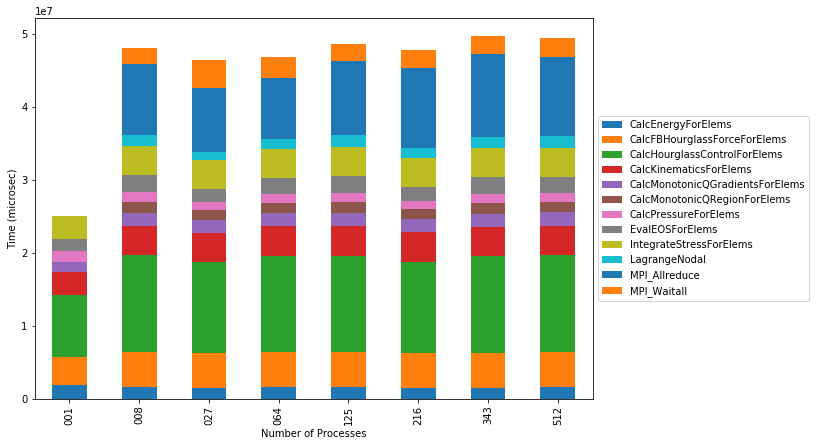

In [72]:
# Figure 13: We read in eight LULESH caliper datasets and create a GraphFrame for each. We then filter the datasets
# to focus on the most time-consuming regions. For plotting, we concatenate all the DataFrames into one while storing
# a key that identifies the number of processes, and then use pivot to rearrange the data in a format more suitable
# for pandas’ plot function. The resulting stacked bar chart is shown on the right.
%matplotlib inline
import glob
import re

datasets = glob.glob(dataset_dir + "/lulesh-scaling/lulesh*.json")
datasets.sort()

dataframes = []
for dataset in datasets:
    gf = ht.GraphFrame.from_caliper_json(dataset)
    gf.drop_index_levels()
    
    num_pes = re.match("(.*)-(\d+)(.*)", dataset).group(2)
    gf.dataframe["pes"] = num_pes
    filtered_gf = gf.filter(lambda x: x["time"] > 1e6)
    dataframes.append(filtered_gf.dataframe)

result = pd.concat(dataframes)
result["pes"] = result["pes"].apply(lambda x: '{0:0>3}'.format(x))
pivot_df = result.pivot(index="pes", columns="name", values="time")
plt = pivot_df.loc[:,:].plot.bar(stacked=True, figsize=(10, 7), legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.set_xlabel("Number of Processes")
plt.set_ylabel("Time (microsec)")